In [0]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing  import LabelEncoder
from sklearn.preprocessing  import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation,BatchNormalization,Dropout,Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
from google.colab import drive 
import tensorflow
drive.mount('/content/drive')

In [12]:
df=shuffle(pd.read_csv("/content/drive/My Drive/data/ymgk/veri_seti.csv", encoding = 'utf8'))
print(df)

        Yil    PM10    SO2  ...  Haftasonu/Haftaici  Ay    Mevsim
9252   2017   67.97  10.27  ...            Haftaici   6       Yaz
6558   2017   21.37   8.17  ...            Haftaici   8       Yaz
8421   2010   77.44  18.14  ...           Haftasonu   1       Kis
19799  2010   30.46   5.99  ...            Haftaici   9  Sonbahar
6315   2018   55.35   3.39  ...            Haftaici   8       Yaz
...     ...     ...    ...  ...                 ...  ..       ...
7369   2017   63.79   8.12  ...            Haftaici   7       Yaz
17373  2017   61.58   5.57  ...            Haftaici  12       Kis
3873   2018   25.79  32.84  ...           Haftasonu   7       Yaz
9932   2010  119.03  11.01  ...            Haftaici  10  Sonbahar
10179  2010   39.26   5.38  ...           Haftasonu   1       Kis

[21531 rows x 17 columns]


In [0]:
le = LabelEncoder()
df["Gece/Gunduz"]=le.fit_transform(df["Gece/Gunduz"])
df["Haftasonu/Haftaici"]=le.fit_transform(df["Haftasonu/Haftaici"])
df["Mevsim"]=le.fit_transform(df["Mevsim"])
labels=LabelEncoder().fit_transform(df["IstasyonTipi"])
y = labels
x = df.drop(["IstasyonTipi"], axis=1)
classes=list(le.fit(df["IstasyonTipi"]).classes_)
nb_classes= len(classes)
nb_features = x.shape[1]

In [0]:
x = StandardScaler().fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25) # 0.25 x 0.8 = 0.2
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)
x_train  = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1],1)
x_valid  = np.array(x_valid).reshape(x_valid.shape[0], x_valid.shape[1],1)
x_test  = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1],1)

In [15]:
model = Sequential()
model.add(LSTM(512,input_shape = (nb_features,1)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.15))
model.add(Dense(2048, activation = "relu"))
model.add(Dropout(0.15))
model.add(Dense(1024, activation = "relu"))
model.add(Dense(nb_classes, activation="softmax"))
model.summary()


from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 512)               1052672   
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              1050624   
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)             

In [16]:
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)

(12918, 16, 1)
(4306, 16, 1)
(4307, 16, 1)


In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
score = model.fit(x_train, y_train, epochs = 50, validation_data=(x_valid,y_valid),batch_size=32)

Epoch 1/50
404/404 [==============================] - 9s 21ms/step - loss: 1.0504 - accuracy: 0.4522 - f1_m: 0.2121 - precision_m: 0.5555 - recall_m: 0.1400 - val_loss: 1.1086 - val_accuracy: 0.3409 - val_f1_m: 0.2294 - val_precision_m: 0.5677 - val_recall_m: 0.1469
Epoch 2/50
404/404 [==============================] - 8s 19ms/step - loss: 1.0157 - accuracy: 0.4851 - f1_m: 0.2742 - precision_m: 0.5854 - recall_m: 0.1848 - val_loss: 1.0355 - val_accuracy: 0.4772 - val_f1_m: 0.3756 - val_precision_m: 0.5371 - val_recall_m: 0.2916
Epoch 3/50
404/404 [==============================] - 7s 19ms/step - loss: 0.9897 - accuracy: 0.5021 - f1_m: 0.3295 - precision_m: 0.6102 - recall_m: 0.2301 - val_loss: 1.0672 - val_accuracy: 0.4380 - val_f1_m: 0.3098 - val_precision_m: 0.5455 - val_recall_m: 0.2191
Epoch 4/50
404/404 [==============================] - 7s 18ms/step - loss: 0.9680 - accuracy: 0.5139 - f1_m: 0.3645 - precision_m: 0.6013 - recall_m: 0.2676 - val_loss: 1.0474 - val_accuracy: 0.4800 

In [18]:
print(("Ortalama Eğitim Kaybı: ", np.mean(model.history.history["loss"])))
print(("Ortalama Eğitim Başarımı: ", np.mean(model.history.history["accuracy"])))
print(("Ortalama Doğrulama Kaybı: ", np.mean(model.history.history["val_loss"])))
print(("Ortalama Doğrulama Başarımı: ", np.mean(model.history.history["val_accuracy"])))
print(("Ortalama F1-Skor Değeri: ", np.mean(model.history.history["f1_m"])))
print(("Ortalama Kesinlik Değeri: ", np.mean(model.history.history["precision_m"])))
print(("Ortalama Duyarlılık Değeri: ", np.mean(model.history.history["recall_m"])))
print(("Ortalama F1-Skor Değeri: ", np.mean(model.history.history["val_f1_m"])))
print(("Ortalama Kesinlik Değeri: ", np.mean(model.history.history["val_precision_m"])))
print(("Ortalama Duyarlılık Değeri: ", np.mean(model.history.history["val_recall_m"])))

('Ortalama Eğitim Kaybı: ', 0.4583758708834648)
('Ortalama Eğitim Başarımı: ', 0.798304693698883)
('Ortalama Doğrulama Kaybı: ', 0.5836225461959839)
('Ortalama Doğrulama Başarımı: ', 0.7570738536119461)
('Ortalama F1-Skor Değeri: ', 0.7709487929940224)
('Ortalama Kesinlik Değeri: ', 0.8278522825241089)
('Ortalama Duyarlılık Değeri: ', 0.7403786081075668)
('Ortalama F1-Skor Değeri: ', 0.7375700479745865)
('Ortalama Kesinlik Değeri: ', 0.7843931603431702)
('Ortalama Duyarlılık Değeri: ', 0.7105385786294938)


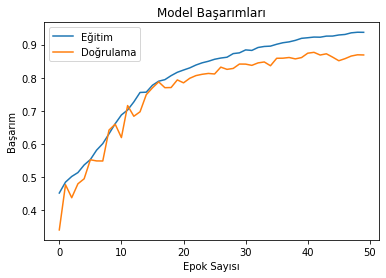

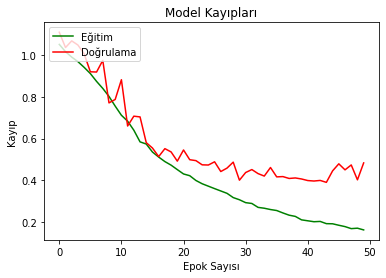

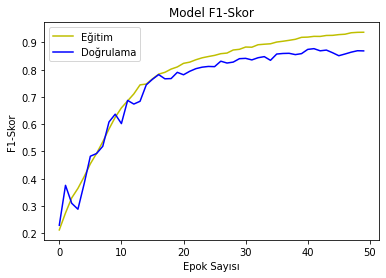

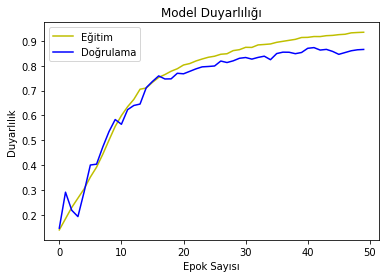

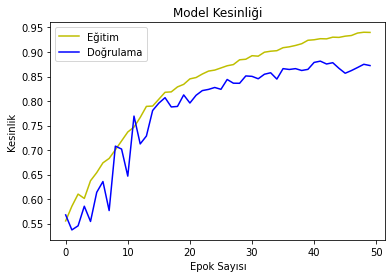

In [19]:
plt.plot(model.history.history["accuracy"])
plt.plot(model.history.history["val_accuracy"])
plt.title("Model Başarımları")
plt.ylabel("Başarım")
plt.xlabel("Epok Sayısı")
plt.legend(["Eğitim","Doğrulama"], loc="upper left")
plt.show()

plt.plot(model.history.history["loss"], color="g")
plt.plot(model.history.history["val_loss"], color="r")
plt.title("Model Kayıpları")
plt.ylabel("Kayıp")
plt.xlabel("Epok Sayısı")
plt.legend(["Eğitim","Doğrulama"], loc="upper left")
plt.show()

plt.plot(model.history.history["f1_m"], color="y")
plt.plot(model.history.history["val_f1_m"], color="b")
plt.title("Model F1-Skor")
plt.ylabel("F1-Skor")
plt.xlabel("Epok Sayısı")
plt.legend(["Eğitim","Doğrulama"], loc="upper left")
plt.show()

plt.plot(model.history.history["recall_m"], color="y")
plt.plot(model.history.history["val_recall_m"], color="b")
plt.title("Model Duyarlılığı")
plt.ylabel("Duyarlılık")
plt.xlabel("Epok Sayısı")
plt.legend(["Eğitim","Doğrulama"], loc="upper left")
plt.show()

plt.plot(model.history.history["precision_m"], color="y")
plt.plot(model.history.history["val_precision_m"], color="b")
plt.title("Model Kesinliği")
plt.ylabel("Kesinlik")
plt.xlabel("Epok Sayısı")
plt.legend(["Eğitim","Doğrulama"], loc="upper left")
plt.show()

34/34 [==============================] - 0s 11ms/step - loss: 0.5029 - accuracy: 0.8530 - f1_m: 0.8551 - precision_m: 0.8590 - recall_m: 0.8512
Kayıp 0.502898633480072
Accuracy 0.8530299663543701
F1 0.8550963997840881
Kesinlik 0.8590242862701416
Duyarlılık 0.8512358665466309


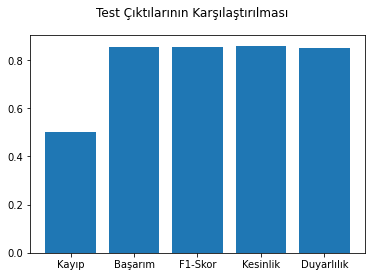

In [32]:
results = model.evaluate(x_test, y_test, batch_size=128)
print("Kayıp" , results[0])
print("Accuracy" , results[1])
print("F1" , results[2])
print("Kesinlik" , results[3])
print("Duyarlılık" , results[4])

isimler = ['Kayıp', 'Başarım','F1-Skor','Kesinlik','Duyarlılık']
degerler =  [ results[0],  results[1], results[2], results[3], results[4]]
plt.bar(isimler, degerler)
plt.suptitle('Test Çıktılarının Karşılaştırılması')
plt.show()

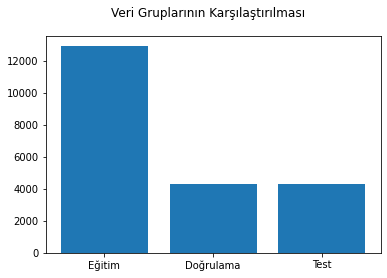

In [30]:
grup = ['Eğitim', 'Doğrulama','Test']
degerler =  [x_train.shape[0], x_valid.shape[0], x_test.shape[0]]
plt.bar(grup, degerler)
plt.suptitle('Veri Gruplarının Karşılaştırılması')
plt.show()
